# Commitment analysis experiments measuring notebook

This notebook takes the output of the 4-channel brightfield, gfp-h2b, rfp-h2b, irfp-pcna/JNK/p38 experiments, and measures various image based properties

In [1]:
import napari
print("Napari version no.:", napari.__version__)
import btrack
print('Btrack version', btrack.__version__)
import os, glob, enum
import numpy as np
import tifffile as tiff
from tqdm import tqdm
from skimage.io import imread
from natsort import natsorted
from datetime import datetime
from btrack.utils import tracks_to_napari
from dask_image.imread import imread
import dask.array as da

Napari version no.: 0.4.11
Btrack version 0.4.2


### Set data folder and number of channels to display

In [2]:
### set root data folder
root_folder = '/home/nathan/data/kraken/commitment/'
expt_IDs = natsorted([ID for ID in os.listdir(root_folder) if 'MK' in ID])
print('Experiment/position list:', [(expt,natsorted([pos for pos in os.listdir(os.path.join(root_folder, expt)) if 'Pos' in pos])) for expt in expt_IDs])
@enum.unique
class channels(enum.Enum):
    bf = 0 
    gfp = 1
    rfp = 2
    irfp = 3
    gfp_cp_masks = 4
    rfp_cp_masks = 5

Experiment/position list: [('MK0000', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'Pos17', 'Pos18', 'Pos19', 'Pos20', 'Pos21', 'Pos22', 'Pos23']), ('MK0000v1', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15', 'Pos16', 'Pos17', 'Pos18', 'Pos19', 'Pos20', 'Pos21', 'Pos22', 'Pos23']), ('MK0001', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15']), ('MK0002', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15']), ('MK0003', ['Pos0', 'Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5', 'Pos6', 'Pos7', 'Pos8', 'Pos9', 'Pos10', 'Pos11', 'Pos12', 'Pos13', 'Pos14', 'Pos15'])]


Select one position to view

In [3]:
expt = 'MK0002'
pos = 'Pos12'

### Load tracks

In [79]:
tracking_fns = [fn for fn in glob.glob(os.path.join(root_folder, expt, pos, '*.h5'))]
[(i,fn) for i, fn in enumerate(tracking_fns)]

[(0,
  '/home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[cell_config].h5'),
 (1,
  '/home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[MDCK_config_scribble_sparse].h5'),
 (2,
  '/home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[MDCK_config_wildtype_dense].h5'),
 (3, '/home/nathan/data/kraken/commitment/MK0002/Pos12/gfp_tracks.h5'),
 (4, '/home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks.h5'),
 (5,
  '/home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[MDCK_config_new].h5')]

In [81]:
gfp_tracks = tracking_fns[3]
rfp_tracks = tracking_fns[4]
#irfp_tracks = tracks_path[3]

# with btrack.dataio.HDF5FileHandler(irfp_tracks, 'r', obj_type = "obj_type_2") as hdf:
#     wt2_tracks = hdf.tracks
with btrack.dataio.HDF5FileHandler(gfp_tracks, 'r', obj_type = "obj_type_1") as hdf:
    gfp_tracks = hdf.tracks
gfp_tracks_render, properties, graph = tracks_to_napari(gfp_tracks, ndim = 2)
with btrack.dataio.HDF5FileHandler(rfp_tracks, 'r', obj_type = "obj_type_2") as hdf:
    rfp_tracks = hdf.tracks
rfp_tracks_render, properties, graph = tracks_to_napari(rfp_tracks, ndim = 2)

print("Tracks loaded")

[INFO][2021/10/20 01:36:30 pm] Opening HDF file: /home/nathan/data/kraken/commitment/MK0002/Pos12/gfp_tracks.h5...
[INFO][2021/10/20 01:36:30 pm] Loading tracks/obj_type_1
[INFO][2021/10/20 01:36:30 pm] Loading objects/obj_type_1 (40156, 5) (40156 filtered: None)
[INFO][2021/10/20 01:36:30 pm] Closing HDF file: /home/nathan/data/kraken/commitment/MK0002/Pos12/gfp_tracks.h5
[INFO][2021/10/20 01:36:30 pm] Opening HDF file: /home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks.h5...
[INFO][2021/10/20 01:36:30 pm] Loading tracks/obj_type_2
[INFO][2021/10/20 01:36:30 pm] Loading objects/obj_type_2 (152904, 5) (152904 filtered: None)
[INFO][2021/10/20 01:36:33 pm] Closing HDF file: /home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks.h5


Tracks loaded


# Measure


#### Plot histogram of rfp track lengths

In [7]:
import matplotlib.pyplot as plt

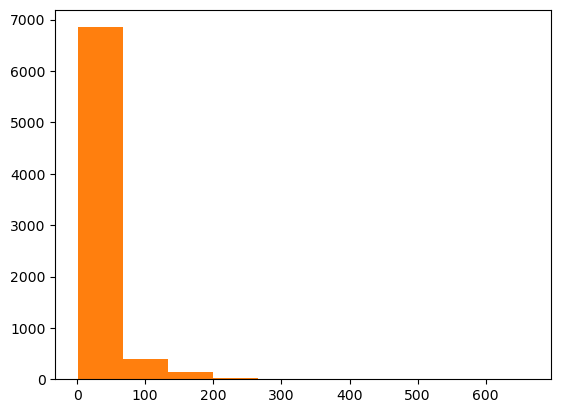

In [9]:
rfp_track_lengths = [len(track) for track in rfp_tracks]
plt.hist(rfp_track_lengths)
plt.show()

In [34]:
### extract longer tracks
long_rfp_tracks = [track for track in rfp_tracks if len(track) > 100]

In [21]:
long_rfp_tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity,area
0,1935,537,819.442505,1338.056396,0.000000,1935,1935,5,0,False,64.171425,1085.0
1,1935,538,821.892151,1338.512573,0.000000,1935,1935,5,0,False,64.024040,1123.0
2,1935,539,820.104675,1338.144043,0.000000,1935,1935,5,0,False,63.907406,1080.0
3,1935,540,820.943909,1336.103394,0.000000,1935,1935,5,0,False,63.213570,1400.0
4,1935,541,820.762146,1335.978516,0.000000,1935,1935,5,0,False,63.425495,1208.0
5,1935,542,822.433716,1337.407227,0.000000,1935,1935,5,0,False,63.402409,1163.0
6,1935,543,824.955017,1337.746948,0.000000,1935,1935,5,0,False,63.233681,1241.0
7,1935,544,825.564575,1337.786865,0.000000,1935,1935,5,0,False,62.900242,1243.0
8,1935,545,828.463684,1338.215820,0.000000,1935,1935,5,0,False,63.157936,1260.0
9,1935,546,829.748779,1337.833496,0.000000,1935,1935,5,0,False,62.695850,1325.0


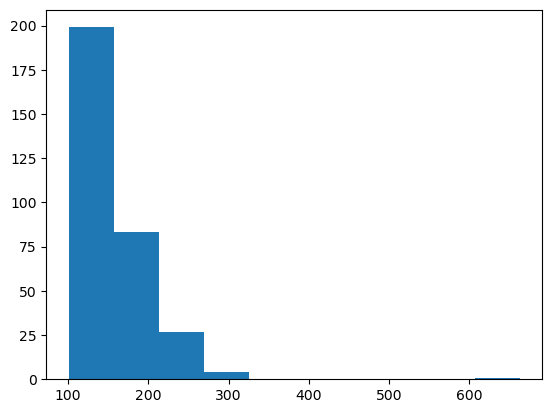

In [35]:
plt.hist([len(track) for track in long_rfp_tracks])
plt.show()

#### take longer rfp tracks and plot mean intensity

In [36]:
mean_intensity = [long_rfp_tracks[i]['mean_intensity'] for i, j in enumerate(long_rfp_tracks)]

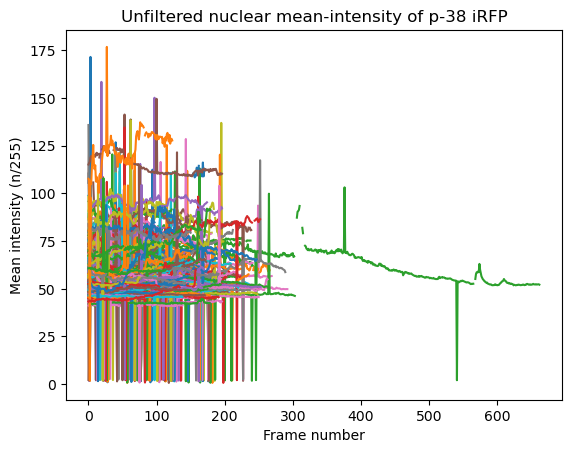

In [40]:
for i in mean_intensity:
    
    plt.plot(i)
plt.title('Unfiltered nuclear mean-intensity of p-38 iRFP')
plt.xlabel('Frame number')
plt.ylabel('Mean intensity (n/255)')
plt.show()

normalise each trajectory and replace 0 with NaN

# inspecting individual trajectories

In [29]:
[(track.ID, len(track)) for track in long_rfp_tracks]

[(1935, 663), (3340, 306)]

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/napari_animation/_qt/keyframeslist_widget.py:156: FutureWarning: Themes were changed to use evented model with Pydantic's color type rather than the `rgb(x, y, z)`. You can get the old color by calling `color.as_rgb()`. The `as_dict=True` option will be removed in 0.X.X
  self.setStyleSheet(template(qss_template, **get_theme(theme_name)))


In [27]:
tracks_of_interest_render, properties, graph = tracks_to_napari(long_rfp_tracks, ndim = 2)

#### take longer rfp tracks and plot mean intensity

In [120]:
mean_intensity = [long_rfp_tracks[i]['mean_intensity'] for i, j in enumerate(long_rfp_tracks) if len(j) > 400]

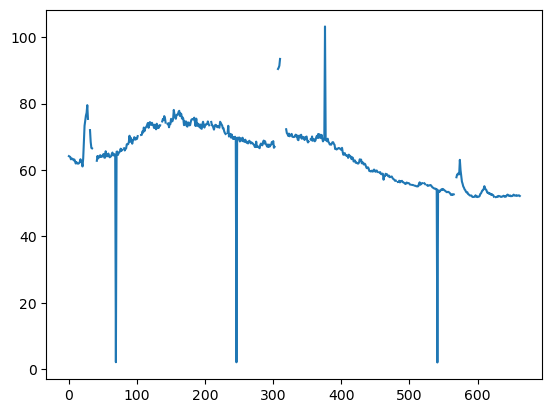

In [121]:
for i in mean_intensity:
    i = remove_outliers(i)
    plt.plot(i)
plt.show()

In [105]:
### replace nan with 0 and remove outliers
i = np.nan_to_num(i, nan = 0)

In [90]:
for n,j in enumerate(i):
    print(n,j)

0 64.17142486572266
1 64.02404022216797
2 63.907405853271484
3 63.21356964111328
4 63.42549514770508
5 63.402408599853516
6 63.233680725097656
7 62.90024185180664
8 63.157936096191406
9 62.69585037231445
10 61.953216552734375
11 62.38242721557617
12 61.99138641357422
13 61.92438888549805
14 61.91755676269531
15 62.08451843261719
16 62.47100067138672
17 63.23640441894531
18 62.51291275024414
19 62.24421310424805
20 61.05740737915039
21 63.493167877197266
22 68.65592956542969
23 73.31778717041016
24 74.84114837646484
25 76.37647247314453
26 77.20199584960938
27 79.51388549804688
28 75.3720932006836
29 0.0
30 0.0
31 72.00875854492188
32 68.44978332519531
33 66.63050842285156
34 66.50328826904297
35 0.0
36 0.0
37 0.0
38 64.32952880859375
39 0.0
40 0.0
41 62.769962310791016
42 64.23004150390625
43 63.476966857910156
44 64.05974578857422
45 63.86819839477539
46 64.45768737792969
47 63.96094512939453
48 63.92776870727539
49 64.11001586914062
50 64.59040832519531
51 64.8064193725586
52 63.7216

In [86]:
def filter_iqr(i):
    # i = mean_intensity_trajectory, a list of image intensities
    i = np.nan_to_num(i, nan = 0)
    Q1 = np.quantile((i),0.25)
    Q3 = np.quantile((i),0.75)
    IQR = Q3 - Q1
    filter_range = (Q1 - 1.5*IQR, Q3 + 1.5*IQR)
    i[i>filter_range[1]] = np.nan
    i[i<filter_range[0]] = np.nan
    return i

# selecting one trajectory

In [90]:
track = [track for track in rfp_tracks if track.ID == 1422][0]

In [93]:
intensity = track['mean_intensity']

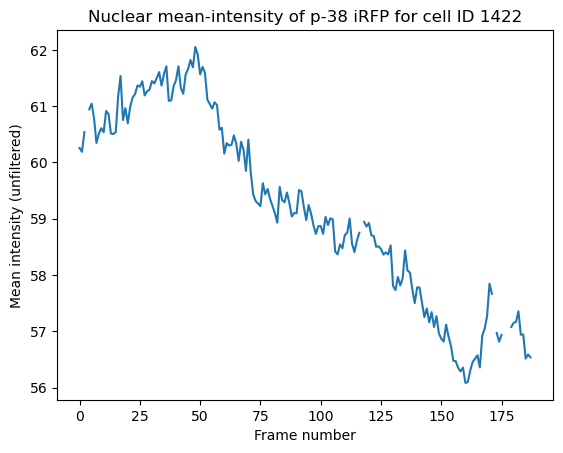

/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/napari_animation/_qt/keyframeslist_widget.py:156: FutureWarning: Themes were changed to use evented model with Pydantic's color type rather than the `rgb(x, y, z)`. You can get the old color by calling `color.as_rgb()`. The `as_dict=True` option will be removed in 0.X.X
  self.setStyleSheet(template(qss_template, **get_theme(theme_name)))


In [96]:
plt.plot(intensity)
plt.title('Nuclear mean-intensity of p-38 iRFP for cell ID 1422')
plt.xlabel('Frame number')
plt.ylabel('Mean intensity (unfiltered)')
plt.show()

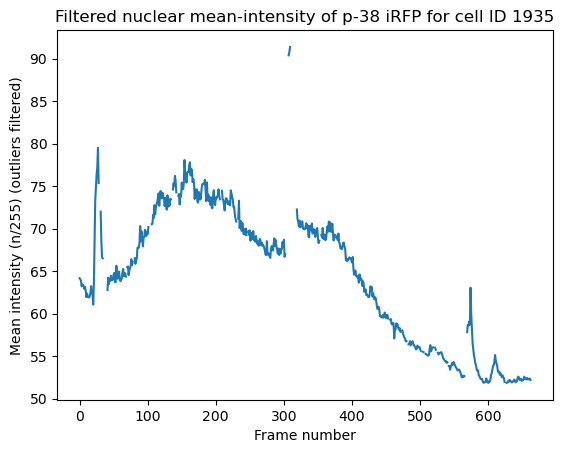

In [122]:
plt.plot(filter_iqr(i))
plt.title('Filtered nuclear mean-intensity of p-38 iRFP for cell ID 1935')
plt.xlabel('Frame number')
plt.ylabel('Mean intensity (n/255) (outliers filtered)')
plt.show()

# partially filtered

In [ ]:
[long_rfp_tracks[i]['mean_intensity'] for i, j in enumerate(long_rfp_tracks)]

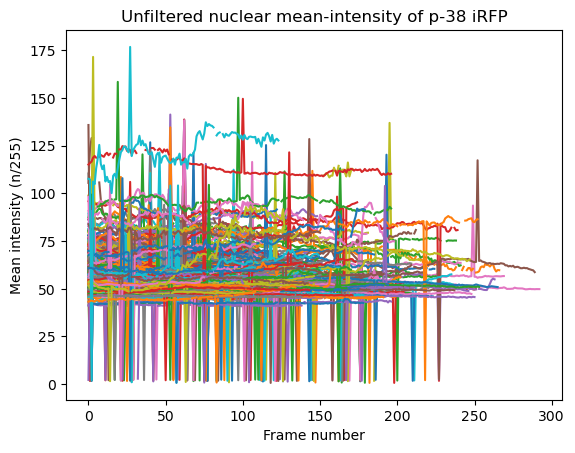

In [110]:
for i in [rfp_tracks[i]['mean_intensity'] for i, j in enumerate(rfp_tracks) if 300>len(j)>100]:
    
    plt.plot(i)
plt.title('Unfiltered nuclear mean-intensity of p-38 iRFP')
plt.xlabel('Frame number')
plt.ylabel('Mean intensity (n/255)')
plt.show()

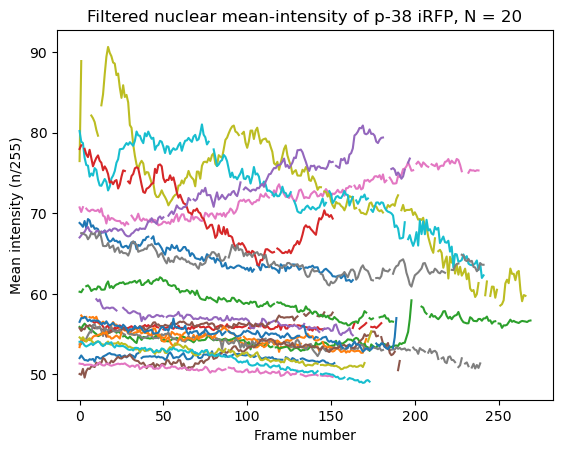

Rendering frame  1 of 100


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1104, 902) to (1104, 912) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Rendering frame  2 of 100
Rendering frame  3 of 100
Rendering frame  4 of 100
Rendering frame  5 of 100
Rendering frame  6 of 100
Rendering frame  7 of 100
Rendering frame  8 of 100
Rendering frame  9 of 100
Rendering frame  10 of 100
Rendering frame  11 of 100
Rendering frame  12 of 100
Rendering frame  13 of 100
Rendering frame  14 of 100
Rendering frame  15 of 100
Rendering frame  16 of 100
Rendering frame  17 of 100
Rendering frame  18 of 100
Rendering frame  19 of 100
Rendering frame  20 of 100
Rendering frame  21 of 100
Rendering frame  22 of 100
Rendering frame  23 of 100
Rendering frame  24 of 100
Rendering frame  25 of 100
Rendering frame  26 of 100
Rendering frame  27 of 100
Rendering frame  28 of 100
Rendering frame  29 of 100
Rendering frame  30 of 100
Rendering frame  31 of 100
Rendering frame  32 of 100
Rendering frame  33 of 100
Rendering frame  34 of 100
Rendering frame  35 of 100
Rendering frame  36 of 100
Rendering frame  37 of 100
Rendering frame  38 of 100
Rendering

In [123]:
count = 0
N = 20
for i in [rfp_tracks[i]['mean_intensity'] for i, j in enumerate(rfp_tracks) if 300>len(j)>150]:
    if count > N:
        break
    i = filter_iqr(i)
    plt.plot(i)
    count +=1
plt.title('Filtered nuclear mean-intensity of p-38 iRFP, N = 20')
plt.xlabel('Frame number')
plt.ylabel('Mean intensity (n/255)')
plt.show()

# inspecting individual trajectories

In [30]:
[(track.ID, len(track)) for track in long_rfp_tracks if len(track) > 400]

[(1935, 663)]

In [31]:
longest_track = [track for track in long_rfp_tracks if len(track) > 400]

In [32]:
longest_track_render, properties, graph = tracks_to_napari(longest_track, ndim = 2)

# inspecting apoptotic tracks

In [143]:
## ONLY SHOW long tracks
long_tracks = [track for track in rfp_tracks if len(track) > 250]
print(len(long_tracks))

12


these tracks all ended in divisions so filtering again  

In [150]:
other_long_tracks = [track for track in rfp_tracks if 230 > len(track) > 210]
print(len(other_long_tracks))

11


In [151]:
long_tracks_render, properties, graph = tracks_to_napari(other_long_tracks, ndim = 2)

inspect negative gradient in mean intensity measures?

In [127]:
apoptotic_tracks = [track for track in rfp_tracks if track.fate.name == 'APOPTOSIS']

In [135]:
for i in range(len(rfp_tracks)):
    print(rfp_tracks[i].fate.name)

FALSE_POSITIVE
TERMINATE_BORDER
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
TERMINATE_BORDER
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
TERMINATE_BORDER
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALS

FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
TERMINATE_BORDER
TERMINATE_BORDER
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
TERMINATE_BORDER
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
TERMINATE_BORDER
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FA

FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
DIVIDE
TERMINATE_BORDER
TERMINATE_BORDER
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
TERMINATE_BORDER
FALSE_POSITIVE
TERMINATE_BORDER
TERMINATE_BORDER
FALSE_POSITIVE
FALSE_POSITIVE
TERMINATE_BORDER
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
FALSE_POSITIVE
TERMINATE_BORDER
FALS

### Launch napari avec tracks

In [156]:
### load images
file_pattern = os.path.join(root_folder, expt, pos, f'{pos}_stacks','{}.tif')
all_channels = [imread(file_pattern.format(channel.name)) for channel in channels]
print([(channel.value, channel.name) for channel in channels])
stack = da.stack(all_channels)
print('stack shape', stack.shape)  

## launch napari using channel.value indexes in stack
viewer = napari.Viewer()
#viewer.add_image(stack[0], name = "brightfield", contrast_limits=[0,200], blending = 'additive')#, is_pyramid=False)
#viewer.add_image(stack[1], name="gfp", contrast_limits=[80,200], blending = 'additive', colormap = 'green')#, is_pyramid=False)
viewer.add_image(stack[2], name="rfp", contrast_limits=[0,30], blending = 'additive', colormap = 'red')#, is_pyramid=False)
viewer.add_image(stack[3], name="irfp", contrast_limits=[0,200], blending = 'additive', colormap = 'cyan')#, is_pyramid=False)
#viewer.add_image(stack[4], name="gfp masks", contrast_limits=[0,1], blending = 'additive', colormap = 'yellow')#, is_pyramid=False) 
viewer.add_image(stack[5], name="rfp masks", opacity = 0.10, contrast_limits=[0,1], blending = 'additive', colormap = 'magenta')#, is_pyramid=False) 

## add tracks
#viewer.add_tracks(gfp_tracks_render)
#viewer.add_tracks(irfp_tracks)
viewer.add_tracks(rfp_tracks_render)
viewer.add_tracks(long_tracks_render, visible=True)
napari.run()

[(0, 'bf'), (1, 'gfp'), (2, 'rfp'), (3, 'irfp'), (4, 'gfp_cp_masks'), (5, 'rfp_cp_masks')]
stack shape (6, 1200, 1352, 1688)


# testing different tracking params out

In [4]:
tracking_fns = [fn for fn in glob.glob(os.path.join(root_folder, expt, pos, 'irfp*v*.h5'))]
[(i,fn) for i, fn in enumerate(tracking_fns)]

[(0,
  '/home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[cell_config].h5'),
 (1,
  '/home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[MDCK_config_scribble_sparse].h5'),
 (2,
  '/home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[MDCK_config_wildtype_dense].h5'),
 (3,
  '/home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[MDCK_config_new].h5')]

In [78]:
len(rfp_tracks)

NameError: name 'rfp_tracks' is not defined

In [7]:
rfp_tracks_cell_config = tracking_fns[0]
rfp_tracks_MDCK_config_scribble_sparse = tracking_fns[1]
rfp_tracks_MDCK_config_wildtype_dense = tracking_fns[2]
rfp_tracks_MDCK_config_new = tracking_fns[3]

with btrack.dataio.HDF5FileHandler(tracking_fns[0], 'r', obj_type = "obj_type_2") as hdf:
    rfp_tracks_cell_config = hdf.tracks
rfp_tracks_cell_config_render, properties0, graph = tracks_to_napari(rfp_tracks_cell_config, ndim = 2)

with btrack.dataio.HDF5FileHandler(tracking_fns[1], 'r', obj_type = "obj_type_2") as hdf:
    rfp_tracks_MDCK_config_scribble_sparse = hdf.tracks
rfp_tracks_MDCK_config_scribble_sparse_render, properties1, graph = tracks_to_napari(rfp_tracks_MDCK_config_scribble_sparse, ndim = 2)

with btrack.dataio.HDF5FileHandler(tracking_fns[2], 'r', obj_type = "obj_type_2") as hdf:
    rfp_tracks_MDCK_config_wildtype_dense = hdf.tracks
rfp_tracks_MDCK_config_wildtype_dense_render, properties2, graph = tracks_to_napari(rfp_tracks_MDCK_config_wildtype_dense, ndim = 2)

with btrack.dataio.HDF5FileHandler(tracking_fns[3], 'r', obj_type = "obj_type_2") as hdf:
    rfp_tracks_MDCK_config_new = hdf.tracks
rfp_tracks_MDCK_config_new_render, properties3, graph = tracks_to_napari(rfp_tracks_MDCK_config_new, ndim = 2)



print("Tracks loaded")

[INFO][2021/10/20 12:58:36 pm] Opening HDF file: /home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[cell_config].h5...
[INFO][2021/10/20 12:58:36 pm] Loading tracks/obj_type_2
[INFO][2021/10/20 12:58:36 pm] Loading objects/obj_type_2 (152904, 5) (152904 filtered: None)
[INFO][2021/10/20 12:58:40 pm] Closing HDF file: /home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[cell_config].h5
[INFO][2021/10/20 12:58:41 pm] Opening HDF file: /home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[MDCK_config_scribble_sparse].h5...
[INFO][2021/10/20 12:58:41 pm] Loading tracks/obj_type_2
[INFO][2021/10/20 12:58:41 pm] Loading objects/obj_type_2 (152904, 5) (152904 filtered: None)
[INFO][2021/10/20 12:58:44 pm] Closing HDF file: /home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[MDCK_config_scribble_sparse].h5
[INFO][2021/10/20 12:58:45 pm] Opening HDF file: /home/nathan/data/kraken/commitment/MK0002/Pos12/irfp_rfp_tracks_v[MDCK_config_wild

Tracks loaded


In [84]:
long_rfp_tracks = [track for track in rfp_tracks if 230> len(track) >100]
long_rfp_tracks_render, properties4, graph = tracks_to_napari(long_rfp_tracks, ndim = 2)


In [97]:
## plot single track
track = [track for track in rfp_tracks if track.ID == 1422]
track_ID_1422, properties5, graph = tracks_to_napari(track, ndim = 2)


In [98]:
### load images
file_pattern = os.path.join(root_folder, expt, pos, f'{pos}_stacks','{}.tif')
all_channels = [imread(file_pattern.format(channel.name)) for channel in channels]
print([(channel.value, channel.name) for channel in channels])
stack = da.stack(all_channels)
print('stack shape', stack.shape) 

## launch napari using channel.value indexes in stack
viewer = napari.Viewer()
#viewer.add_image(stack[0], name = "brightfield", contrast_limits=[0,200], blending = 'additive')#, is_pyramid=False)
#viewer.add_image(stack[1], name="gfp", contrast_limits=[80,200], blending = 'additive', colormap = 'green')#, is_pyramid=False)
viewer.add_image(stack[2], name="rfp", contrast_limits=[0,30], blending = 'additive', colormap = 'red')#, is_pyramid=False)
viewer.add_image(stack[3], name="irfp", contrast_limits=[0,200], blending = 'additive', colormap = 'cyan')#, is_pyramid=False)
#viewer.add_image(stack[4], name="gfp masks", contrast_limits=[0,1], blending = 'additive', colormap = 'yellow')#, is_pyramid=False) 
viewer.add_image(stack[5], name="rfp masks", opacity = 0.10, contrast_limits=[0,1], blending = 'additive', colormap = 'magenta')#, is_pyramid=False) 

## add tracks
viewer.add_tracks(rfp_tracks_MDCK_config_new_render)
viewer.add_tracks(rfp_tracks_MDCK_config_wildtype_dense_render)
viewer.add_tracks(rfp_tracks_MDCK_config_scribble_sparse_render)
viewer.add_tracks(rfp_tracks_cell_config_render)
viewer.add_tracks(long_rfp_tracks_render)
viewer.add_tracks(track_ID_1422)
napari.run()

[(0, 'bf'), (1, 'gfp'), (2, 'rfp'), (3, 'irfp'), (4, 'gfp_cp_masks'), (5, 'rfp_cp_masks')]
stack shape (6, 1200, 1352, 1688)


# meta analysis of track length for different params

In [10]:
import matplotlib.pyplot as plt

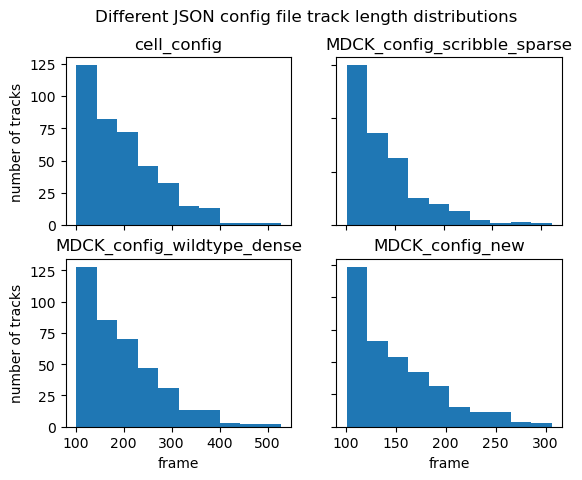

In [76]:
N = 100 ## filter tracks below this length

fig, axs = plt.subplots(2, 2)

fig.suptitle('Different JSON config file track length distributions')

axs[0,0].hist([len(track) for track in rfp_tracks_cell_config if len(track) > N])
axs[0,0].set_title('cell_config') 
axs[0,1].hist([len(track) for track in rfp_tracks_MDCK_config_scribble_sparse if len(track) > N])
axs[0,1].set_title('MDCK_config_scribble_sparse') 
axs[1,0].hist([len(track) for track in rfp_tracks_MDCK_config_wildtype_dense if len(track) > N])
axs[1,0].set_title('MDCK_config_wildtype_dense') 
axs[1,1].hist([len(track) for track in rfp_tracks_MDCK_config_new if len(track) > N])
axs[1,1].set_title('MDCK_config_new') 

for ax in axs.flat:
    ax.set(xlabel='frame', ylabel='number of tracks')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()
plt.clf()

<Figure size 640x480 with 0 Axes>

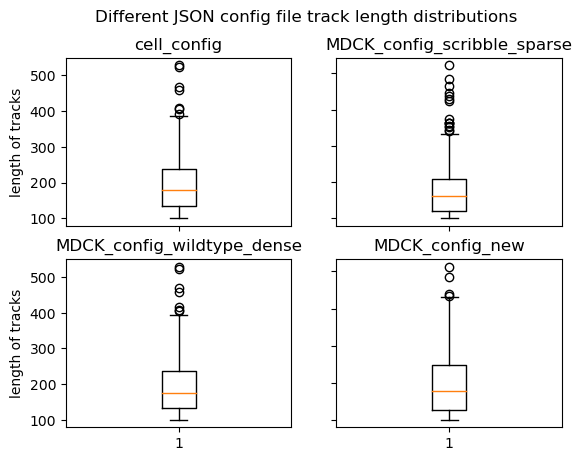

In [40]:
N = 100 ## filter tracks below this length

fig, axs = plt.subplots(2, 2)

fig.suptitle('Different JSON config file track length distributions')

axs[0,0].boxplot([len(track) for track in rfp_tracks_cell_config if len(track) > N])
axs[0,0].set_title('cell_config') 
axs[0,1].boxplot([len(track) for track in rfp_tracks_MDCK_config_scribble_sparse if len(track) > N])
axs[0,1].set_title('MDCK_config_scribble_sparse') 
axs[1,0].boxplot([len(track) for track in rfp_tracks_MDCK_config_wildtype_dense if len(track) > N])
axs[1,0].set_title('MDCK_config_wildtype_dense') 
axs[1,1].boxplot([len(track) for track in rfp_tracks_MDCK_config_new if len(track) > N])
axs[1,1].set_title('MDCK_config_new') 

for ax in axs.flat:
    ax.set(xlabel='', ylabel='length of tracks')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()
plt.clf()

<Figure size 640x480 with 0 Axes>

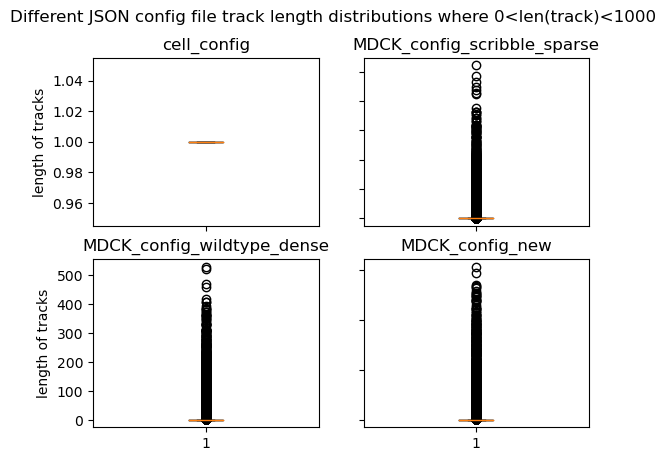

In [66]:
N = 0 ## filter tracks above this length
n = 1000 ## less than this length
fig, axs = plt.subplots(2, 2)

fig.suptitle(f'Different JSON config file track length distributions where {N}<len(track)<{n}')

axs[0,0].boxplot([len(track) for track in rfp_tracks_cell_config if n > len(track) > N], showfliers=False)
axs[0,0].set_title('cell_config') 
axs[0,1].boxplot([len(track) for track in rfp_tracks_MDCK_config_scribble_sparse if n > len(track) > N])
axs[0,1].set_title('MDCK_config_scribble_sparse') 
axs[1,0].boxplot([len(track) for track in rfp_tracks_MDCK_config_wildtype_dense if n > len(track) > N])
axs[1,0].set_title('MDCK_config_wildtype_dense') 
axs[1,1].boxplot([len(track) for track in rfp_tracks_MDCK_config_new if n > len(track) > N])
axs[1,1].set_title('MDCK_config_new') 

for ax in axs.flat:
    ax.set(xlabel='', ylabel='length of tracks')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.show()
plt.clf()

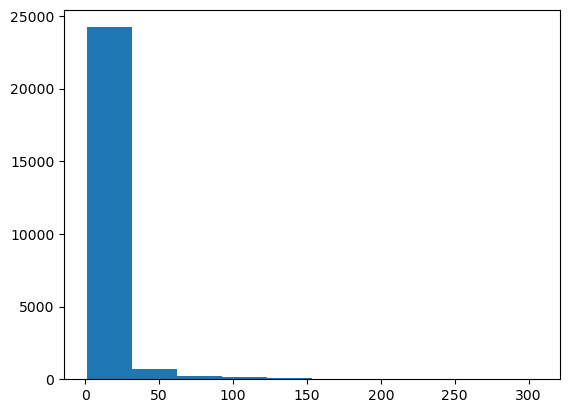

In [67]:
plt.hist([len(track) for track in tracks if len(track)])
plt.show()

In [70]:
len(tracks), len([track for track in tracks if len(track) == 1])

(25472, 20846)

In [75]:
len([track for track in tracks if len(track) == 6])

197